In [17]:
%matplotlib
%pylab inline
import mxnet as mx
import numpy as np
import cv2
import cvutils
from skimage import io, transform

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


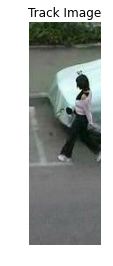

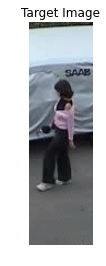

In [18]:
# Load the images
im_image = cv2.imread("./image.jpg")
im_target = cv2.imread("./target.jpg")
# Display the images
cvutils.imshow("Track Image", im_image)
cvutils.imshow("Target Image", im_target)

In [25]:
size = 227
def PreprocessImage(path, show_img=True):
    # load image
    img = io.imread(path)
    print("Original Image Shape: ", img.shape)

    resized_img = transform.resize(img, (size, size))
    if show_img:
        io.imshow(resized_img)
    # convert to numpy.ndarray
    sample = np.asarray(resized_img) * 256

    sample = np.swapaxes(sample, 0, 2)
    sample = np.swapaxes(sample, 1, 2)
    print ("Processed Image Shape: ", sample.shape)
    # sub mean
    normed_img = sample - 128.
    return np.reshape(normed_img, (1, 3, size, size))

('Original Image Shape: ', (250, 80, 3))
('Processed Image Shape: ', (3, 227, 227))


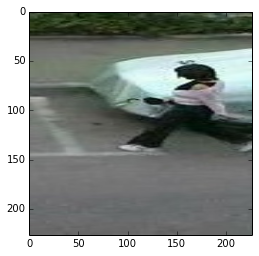

In [28]:
# Get preprocessed batch (single image batch)
image = PreprocessImage('./image.jpg', True)

('Original Image Shape: ', (206, 58, 3))
('Processed Image Shape: ', (3, 227, 227))


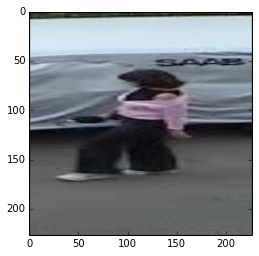

In [27]:
target = PreprocessImage('./target.jpg', True)

In [20]:
# load symbol and params
sym, arg_params, aux_params = mx.model.load_checkpoint("tracker", 1)

In [21]:
ctx=mx.gpu()
arg_params['target'] = mx.nd.array(target, ctx)
arg_params['image'] = mx.nd.array(image, ctx)

In [22]:
executor = sym.bind(ctx, arg_params, args_grad=None, grad_req='null', aux_states=aux_params)
executor.forward(is_train=False)

In [23]:
output_dict = {name: nd for name, nd in zip(sym.list_outputs(), executor.outputs)}
out = output_dict['fc8_shapes_output'].asnumpy()

(33, 43) (73, 161)


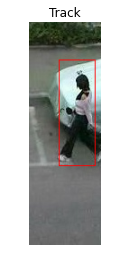

In [24]:
scalar = 10.0
shape = im_image.shape
top_left=((int)(out[0][0]/scalar*shape[1]+0.5), (int)(out[0][1]/scalar*shape[0]+0.5))
bottom_right=((int)(out[0][2]/scalar*shape[1]+0.5), (int)(out[0][3]/scalar*shape[0]+0.5))
print top_left, bottom_right
im_display = im_image.copy()
cv2.rectangle(im_display, top_left, bottom_right, (0,0,255), 1)
cvutils.imshow("Track", im_display)